In [1]:
import numpy as np
import matplotlib.pyplot as plt

<h1>Geometry</h1>

All the particles will evolve inside a 2D rectangle with one missing wall. This rectangle has a length $L$ and a height $h$.

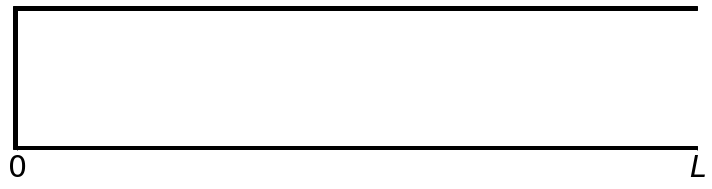

In [2]:
L = 5
h = 1
lw = 0.025

def create_base_plot():
    fig,ax1 = plt.subplots(1,1,figsize=(10,3))
    ax1.set_aspect('equal')
    ax1.add_patch(plt.Rectangle((0, -lw), L, lw, fill=True, facecolor='black', edgecolor='black', clip_on=False))
    ax1.add_patch(plt.Rectangle((0, h), L, lw, fill=True, facecolor='black', edgecolor='black', clip_on=False))
    ax1.add_patch(plt.Rectangle((-lw, -lw), lw, h+2*lw, fill=True, facecolor='black', edgecolor='black', clip_on=False))
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_xticks([0, L])
    ax1.set_xticklabels(['$0$', '$L$'], fontsize=30)

    plt.tight_layout()
    return fig, ax1

fig, ax1 = create_base_plot()
plt.show()

<h1>Particles</h1>

Now let's add some particles at random locations but limited to the far left end of the box. These particles are point-like and don't interact with other particles but do experience elastic collisions with the walls of the box and obstacles that will be introduced later. Also all particles have a random initial velocity with an $x$ component pointing in the direction of the exit or $x = L$. You might recall these set of assumptions from the derivation of the ideal gas in Thermodynamics.

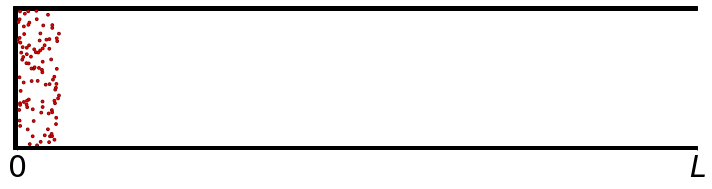

In [3]:
N = 100 # Number of particles
particles = []
particle_radius = 0.01

def create_simple_particle(ax=None):
    x = np.random.random()*L/16
    y = np.random.random()*h   
    vx = np.random.random()*L/100 * (1 if np.random.random() < 0.5 else -1)
    vy = np.random.random()*L/100 * (1 if np.random.random() < 0.5 else -1)
    return {
        'x'      : x,
        'y'      : y,
        'vx0'    : vx,
        'vx'     : vx,
        'vy'     : vy,
        'marker' : (ax.add_patch(plt.Circle((x,y),
                                            particle_radius, 
                                            fill=True,
                                            facecolor='red',
                                            edgecolor='darkred'))
                    if ax != None 
                    else None)
    }

fig, ax1 = create_base_plot()
for n in range(N):
    particles.append(create_simple_particle(ax1))

plt.show()

<h1>Setting up the physical rules</h1>

In the previous section we listed assumptions about the particles but said little about its equations of motion. If the only external force is one due to gravitational acceleration in the $x$ direction we do a newtonian balance of forces for each component as follows 
$$
\begin{aligned}
\sum F_x &= ma_x\\
      mg &= ma_x\\
      g &= \frac{d v_x}{dt}\\
      v_x &= gt + v_{x0}
\end{aligned}
$$

Similarly for the $y$ direction we obtain
$$
\begin{aligned}
    \frac{d v_y}{dt} &= 0\\
    v_y &= v_{y0}
\end{aligned}
$$

Where $v_{x0}$ and $v_{y0}$ are the random speeds assigned by the python method <b>create_particle</b>. Let's animate the particles for the purposes of demonstration and quality check. When attempting to derive Darcy's law, we'll be ignoring the animation to focus more on the statistical aspects of running many simulations.

<IPython.core.display.Javascript object>


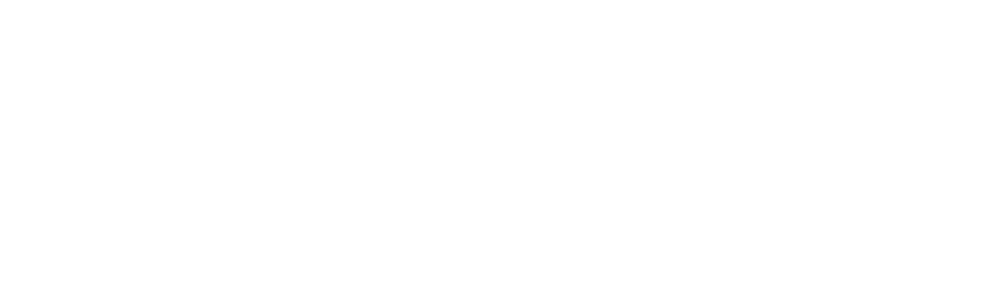

In [4]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

N = 100
dt = 0.1
g = 0.01

fig, ax1 = create_base_plot()
particles = []
for n in range(N):
    particles.append(create_simple_particle(ax1))

def update(frame):
    for p in particles:
        p['vx'] = g*frame*dt + p['vx0']
        p['x'] = p['x'] + p['vx']*dt
        p['y'] = p['y'] + p['vy']*dt
        p['marker'].center = p['x'], p['y']
        
    return map(lambda p: p['marker'][0], particles)

animation = FuncAnimation(fig, update, 
                          frames=100, 
                          blit=True, 
                          interval=1/60, 
                          repeat=False)
plt.show()


<h1>Obstacles and porous media</h1>

Before we add collisions, let's take a moment to introduce more complicated geometries. The end goal here is to test if we can numerically derive Darcy's law. This involves a pressure differential across a porous material and a fluid contained inside it. To simulate pores we're going to add wall-like obstacles to our box so that the particles can collide with them and take a more complicated route from $x = 0$ to $x = L$.

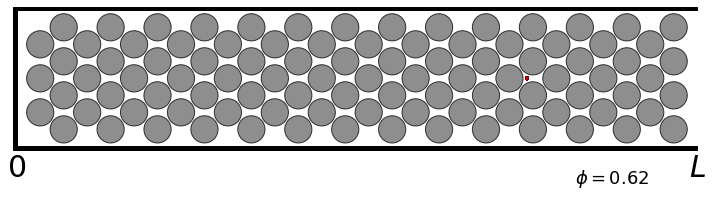

In [62]:
%matplotlib inline
from matplotlib.patches import Rectangle

N = 100
dt = 0.1
obstacle_radius = 0.1
particle_radius = 0.01

def annotate_phi(ax, obstacles):
    if len(obstacles) > 0:
        obs_area = np.pi*obstacle_radius**2
        phi = round(len(obstacles)*obs_area/(L*h), 2)    
    else:
        phi = 0
    ax.text(L - L/8, -0.275, f'$\\phi = {phi}$', fontsize=18, horizontalalignment='center')

def add_obstacles(ax, rows, cols):    
    obstacles = []
    col_domain = np.linspace(0, L, cols)
    row_domain, dr = np.linspace(0, h, rows, retstep=True)
    for k1,i in enumerate(col_domain):
        for k2,j in enumerate(row_domain):
            is_even_col = (k1 % 2 == 0)
            x = i
            y = j + (dr/2 if is_even_col else 0)
            if 0 < x < L and 0 < y < h:
                obstacles.append({
                        'x' : x,
                        'y' : y,
                })
                ax.add_patch(plt.Circle((x, y), obstacle_radius, 
                                        facecolor='dimgrey',
                                        edgecolor='black',
                                        alpha=0.75,
                                        fill=True,
                                        clip_on=False))
    return obstacles

def create_particle(ax, obstacles):
    def is_particle_on_obstacle(x,y):        
        if (h - y) <= particle_radius: # Top wall
            return True
        if y <= particle_radius: # Bottom wall
            return True
        if x <= particle_radius: # Left wall
            return True
        
        for o in obstacles:
            d = np.sqrt((o['x'] - x)**2 + (o['y'] - y)**2)
            if d <= (particle_radius + obstacle_radius):
                return True
        return False

    x = np.random.random()*L/16
    y = np.random.random()*h    

    attempts = 0
    while is_particle_on_obstacle(x,y):
        x = np.random.random()*L/16
        y = np.random.random()*h        
        attempts += 1
        assert attempts < 1000, 'Something went wrong, review is_particle_on_obstacle'
    
    #vx = np.random.random()*L/100 * (1 if np.random.random() < 0.5 else -1)
    #vy = np.random.random()*L/100 * (1 if np.random.random() < 0.5 else -1)

    x = L/2 + L/4
    y = h/2
    vx = -0.05
    vy = 0
    return {
        'x'      : x,
        'y'      : y,
        'vx'     : vx,
        'vy'     : vy,
        'marker' : (ax.add_patch(plt.Circle((x,y),
                                            particle_radius, 
                                            fill=True,
                                            facecolor='red',
                                            edgecolor='darkred'))
                    if ax != None
                    else None)
    }

fig, ax1 = create_base_plot()
obstacles = add_obstacles(ax1, 5, 30)
particles = []
for n in range(N):
    particles.append(create_particle(ax1, obstacles))

annotate_phi(ax1, obstacles)
    
plt.show()

We defined $\phi$ as the ratio of obstacle area to total area for reference. Now for the movement part. We are going to restrict our simulation parameters to slow speeds and a small $dt$. This choice simplifies the task of collision detection signifincantly. Now we can simply update the position of the particles and check for collsions then. The displacements won't be large enough for particles to <i>go through walls</i>.

<IPython.core.display.Javascript object>


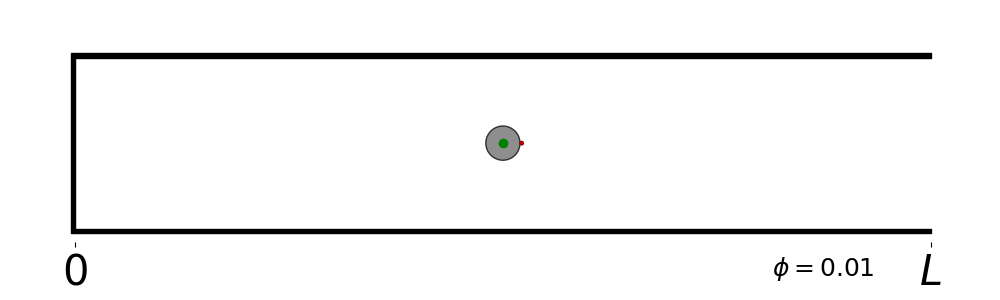

x0=2.6096625000000437, y0=0.5, vx=0.014700000000000853, vy=0
xf=2.610400000000044, yf=0.5
tc=0.022881355929236295, residual=0.05
wx=2.5, wy=0.5


C:\Users\jpalacios\AppData\Local\Temp\ipykernel_17672\3476310240.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  tc = residual*(xwp - x0p + sign*(particle_radius + obstacle_radius))/(xfp - x0p)


AssertionError: 

In [67]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

N = 1
dt = 0.05
g = 1e-3

def to_cfr(x, y, θ):
    """ Rotate a 2D vector by θ radians """
    return (
        x*np.cos(θ) - y*np.sin(θ),
        x*np.sin(θ) + y*np.cos(θ)
    )

def update_velocity_and_position(p,n,residual):
    # Parametrize trajectory
    y0 = p['y']
    yf = p['y'] + p['vy']*residual
    x0 = p['x']
    vxf = p['vx'] + g*residual
    xf = p['x'] + vxf*residual
    
    # Top wall
    if (yf - y0) != 0:
        tc = residual*(h - particle_radius - y0)/(yf - y0)
        if 0 < tc <= residual:
            residual -= tc
            p['vx'] = p['vx'] + g*tc
            p['x'] = p['x'] + p['vx']*tc
            p['y'] = h - particle_radius
            p['vy'] = -p['vy']            
            if not np.isclose(0, residual):
                update_velocity_and_position(p, n, residual)
            else:
                return

    # Bottom wall
    if (yf - y0) != 0:
        tc = residual*(particle_radius - y0)/(yf - y0)
        if 0 < tc <= residual:
            residual -= tc
            p['vx'] = p['vx'] + g*tc
            p['x'] = p['x'] + p['vx']*tc
            p['y'] = particle_radius
            p['vy'] = -p['vy']            
            if not np.isclose(0, residual):
                update_velocity_and_position(p, n, residual)
            else:
                return
    
    # Left wall
    if (xf - x0) != 0:
        tc = residual*(particle_radius - x0)/(xf - x0)
        if 0 < tc <= residual:
            residual -= tc
            p['vx'] = p['vx'] + g*tc        
            p['x'] = particle_radius
            p['y'] = p['y'] + p['vy']*tc        
            p['vx'] = -p['vx']
            if not np.isclose(0, residual):
                update_velocity_and_position(p, n, residual)
            else:
                return
        
    # It's cheap to check all obstacles even if they're too 
    # far for a collision to happen   
    if not np.isclose(0, residual):
        for w in obstacles:
            θ = np.arccos(p['vx']/np.sqrt(p['vx']**2 + p['vy']**2))
            x0p, y0p = to_cfr(p['x'], p['y'], θ)
            xfp, yfp = to_cfr(xf, yf, θ)
            xwp, ywp = to_cfr(w['x'], w['y'], θ)
            sign = -1 if (w['x'] > p['x']) else 1
            tc = residual*(xwp - x0p + sign*(particle_radius + obstacle_radius))/(xfp - x0p)
            if 0 < tc <= residual and np.abs(y0p - ywp) <= (particle_radius + obstacle_radius):
                print(f'x0={x0}, y0={y0}, vx={p["vx"]}, vy={p["vy"]}')
                print(f'xf={xf}, yf={yf}')
                print(f'tc={tc}, residual={residual}')
                print(f'wx={w["x"]}, wy={w["y"]}')
                ax1.plot(w['x'], w['y'], 'go')
                assert False
                # Move to collision point
                residual -= tc
                p['vx'] = p['vx'] + g*tc
                p['x'] = p['x'] + p['vx']*tc
                p['y'] = p['y'] + p['vy']*tc                               
                p['vx'] = -p['vx']
                p['vy'] = -p['vy']
                if not np.isclose(0, residual):
                    update_velocity_and_position(p, n, residual)
                else:
                    return
    
    if not np.isclose(0, residual):
        p['vx'] = p['vx'] + g*residual
        p['x'] = p['x'] + p['vx']*residual
        p['y'] = p['y'] + p['vy']*residual
        residual = 0

def update(frame):
    for p in particles:
        update_velocity_and_position(p, frame, dt)        
        p['marker'].center = p['x'], p['y']
    return map(lambda p: p['marker'][0], particles)

fig, ax1 = create_base_plot()
obstacles = add_obstacles(ax1, 3, 3)
particles = []
for n in range(N):
    particles.append(create_particle(ax1, obstacles))

annotate_phi(ax1, obstacles)

for n in range(5000):
    update(n)

# animation = FuncAnimation(fig, update, 
#                           frames=10000, 
#                           blit=True, 
#                           interval=1,
#                           repeat=False)
plt.show()